# Titanic Classification Model - a first attempt at Machine Learning
### CRISP-DM Steps:

<ol>
    <li>[Business Understanding](#business_understanding)</li>
    <li>[Data Understanding](#data_understanding)</li>
        <ol>
            <li>[Common functions](#common_funcs)</li>
            <li>[Import libraries and dataFrame](#import_libs_and_df)</li>
            <li>[Data visualization](#data_visualization)</li>
        </ol>
    <li>[Data Preparation](#data_preparation)</li>
        <ol>
            <li>[Data transformation](#data_transform)</li>
            <li>[Feature engineering](#feature_engineer)</li>
            <li>[Create training and test sets](#train_test_sets)</li>
        </ol>
    <li>[Modeling](#modeling)</li>
    <li>[Evaluation](#evaluation)</li>
    <li>[Deployment](#deployment)</li>
</ol>

## <a id=business_understanding>1 - Business Understanding</a>

Competition Description:
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

## <a id=data_understanding>2 - Data Understanding</a>

### <a id=common_funcs>2.A - Define common functions</a>

In [80]:
def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    
def describe_categorical(X):
    """
    This will create a table for looking at the categorical variables based on the dtype
    """
    from IPython.display import display, HTML
    display(HTML(X[X.columns[X.dtypes == 'object']].describe().to_html()))
      
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna(0) # fill missing datapoints with 0s
    df.Cabin = df.Cabin.apply(lambda x: 0 if x == 0 else 1) # switch all non-zero entries to 1
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    
    
def drop_features(df):
    return df.drop(['Ticket', 'Name'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'Embarked', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

 

### <a id=import_libs_and_df>2.2 - Import Libraries and DataFrame</a>

In [81]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.metrics import make_scorer, accuracy_score

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split , StratifiedKFold, KFold
from sklearn.feature_selection import RFECV

# Configure visualisations
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
plt.rcParams[ 'figure.figsize' ] = 8 , 6
%matplotlib inline

In [82]:
data_train = pd.read_csv('./input/train.csv')
data_test = pd.read_csv('./input/test.csv')

In [83]:
data_train.describe() 

#Note for Data Cleanup & Encoding: Age is missing entries (only 714 of 891 provided)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [84]:
data_train.info() 

# Note for Data Cleanup & Encoding: there are 5 object features which are most likely categories.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [85]:
describe_categorical(data_train)

# Embarked is missing 2 entries, Cabin is missing 687.  Sex, as expected consists of only two unique possibilities.

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Padro y Manent, Mr. Julian",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


In [86]:
data_train.sample(5)

# Here we see a sample of what the Train data records look like

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
517,518,0,3,"Ryan, Mr. Patrick",male,NaN,0,0,371110,24.1500,NaN,Q
876,877,0,3,"Gustafsson, Mr. Alfred Ossian",male,20.0,0,0,7534,9.8458,NaN,S
93,94,0,3,"Dean, Mr. Bertram Frank",male,26.0,1,2,C.A. 2315,20.5750,NaN,S
508,509,0,3,"Olsen, Mr. Henry Margido",male,28.0,0,0,C 4001,22.5250,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.5500,NaN,S


In [87]:
data_test.describe()

# In the test data, once again Age is missing entries.  Fare is missing one entry.

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [88]:
data_test.sample(5)

# # Here we see a sample of what the Train data records look like.  Note that Survived is NOT a feature here.

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
198,1090,2,"Baimbrigge, Mr. Charles Robert",male,23.0,0,0,C.A. 31030,10.5000,NaN,S
347,1239,3,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,2688,7.2292,NaN,C
14,906,1,"Chaffee, Mrs. Herbert Fuller (Carrie Constance...",female,47.0,1,0,W.E.P. 5734,61.1750,E31,S
243,1135,3,"Hyman, Mr. Abraham",male,NaN,0,0,3470,7.8875,NaN,S
163,1055,3,"Pearce, Mr. Ernest",male,NaN,0,0,343271,7.0000,NaN,S


### <a id=data_visualization>2.3 - Data Visualization</a>
Recognize underlying patterns that can be exploited by visualizing the data.

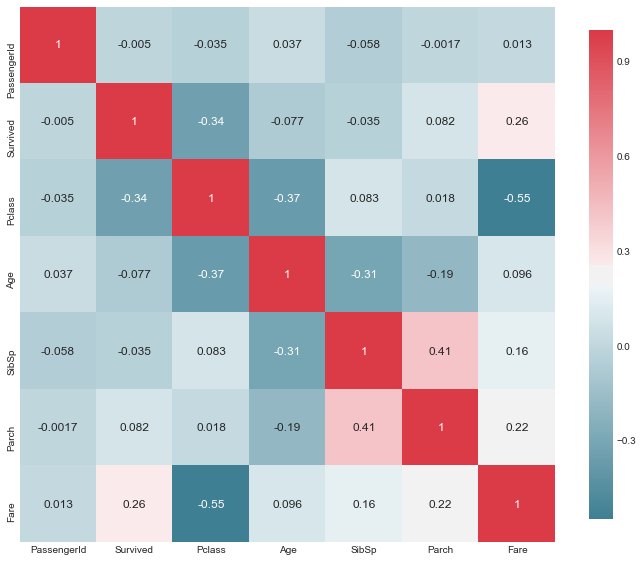

In [89]:
plot_correlation_map(data_train)

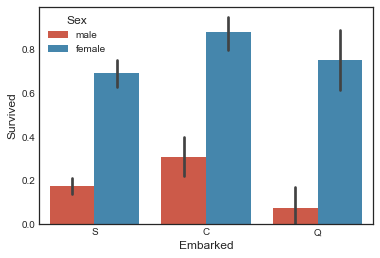

In [90]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=data_train);

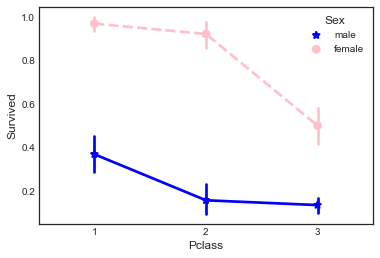

In [91]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data_train,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"]);

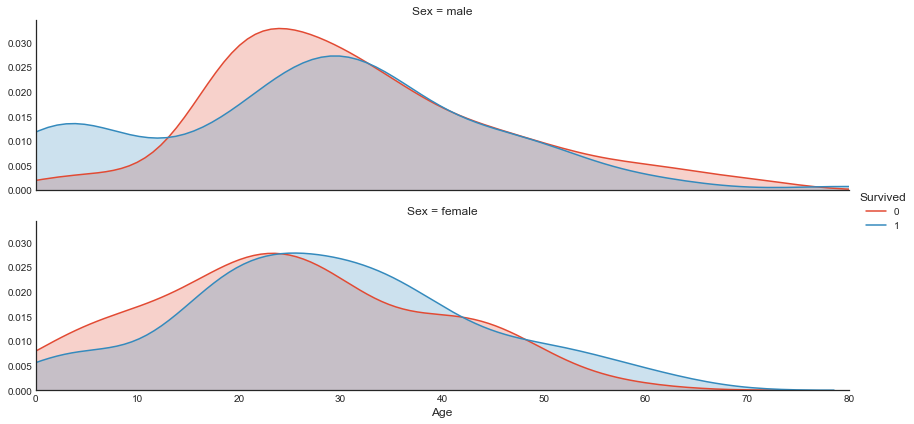

In [92]:
# Plot distributions of Age of passengers who survived or did not survive
plot_distribution( data_train , var = 'Age' , target = 'Survived' , row = 'Sex' )

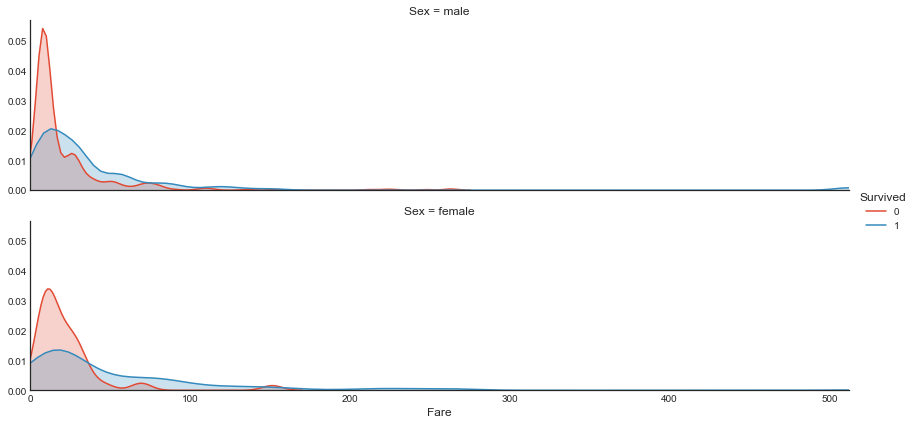

In [93]:
# Plot distributions of Fare of passengers who survived or did not survive
plot_distribution( data_train , var = 'Fare' , target = 'Survived' , row = 'Sex' )

### <a id=data_transform>3.1 - Data Transformation</a>

#### To supply the missing ages, calc the mean and median values

In [94]:
print("There is a mean age of {}, and a median of {}.  Which is most appropriate?".format(
    data_train['Age'].mean(), data_train.Age.median()))

There is a mean age of 29.69911764705882, and a median of 28.0.  Which is most appropriate?


#### Choose the median age since more of the population is younger than the mean.  Update both sets accordingly.

In [95]:
data_train['Age'].fillna(data_train.Age.median(), inplace=True)
data_test['Age'].fillna(data_test.Age.median(), inplace=True)

#### To supply the missing fare, calc the mean and median values.

In [96]:
print("There is a mean fare of {}, and a median of {}.  Which is most appropriate?".format(
    data_test['Fare'].mean(), data_test.Fare.median()))

There is a mean fare of 35.6271884892086, and a median of 14.4542.  Which is most appropriate?


#### Let's go with the median again as it's much lower than the mean.  Update test set accordingly.

In [97]:
data_test['Fare'].fillna(data_test.Fare.median(), inplace=True)

#### To supply the missing Embarked locations, determine the frequency of the three unique values

In [98]:
data_train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

#### So let's go with S as it's the dominent boarding location

In [99]:
data_train['Embarked'].fillna('S', inplace=True)
data_test['Embarked'].fillna('S', inplace=True)

#### We will simplify Ages, Cabins, Fares, Names and remove unneeded features to avoid overfitting.  These functions are defined above and called collectively through the transform_features function.

In [100]:
data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,0,S,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,1,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,0,S,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,1,S,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,0,S,"Allen,",Mr.


#### Final encoding by normalizing labels

In [101]:
data_train, data_test = encode_features(data_train, data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,0,2,100,19
1,2,1,1,0,0,1,0,3,1,0,182,20
2,3,1,3,0,6,0,0,0,0,2,329,16
3,4,1,1,0,6,1,0,3,1,2,267,20
4,5,0,3,1,6,0,0,1,0,2,15,19


### <a id=feature_engineer>3.2 - Feature Engineering</a>

#### TBD

### <a id=train_test_set>3.3 - Create Training and Test Sets</a>

In [102]:
X_all = data_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = data_train.pop('Survived') #Grabs just the Survived feature for y, ignores all others

In [103]:
t_size = 0.20  #t_size=0.2 will set aside 20% of our data for testing
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=t_size, random_state=42) 

## <a id=modeling>4 - Modeling</a>

Select only one of the following classification models by removing the leading '#' character.

In [104]:
model = LogisticRegression()
# model = RandomForestClassifier(n_estimators=100)
# model = SVC() # Support Vector Machines model
# model = GradientBoostingClassifier()
# model = GaussianNB()  # Gaussian Naive Baysian model
# model = KNeighborsClassifier(n_neighbors = 3)

In [105]:
model.fit( X_train , y_train )  # may take a few minutes depending of the computational resources available to you.

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [106]:
# Score the model
print (model.score( X_train , y_train ))

0.806179775281


## <a id=evaluation>5 - Evaluation</a>

In [107]:
def run_kfold(clf):
    kf = KFold(891, n_folds=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(model)

Fold 1 accuracy: 0.8111111111111111
Fold 2 accuracy: 0.8202247191011236
Fold 3 accuracy: 0.7528089887640449
Fold 4 accuracy: 0.8426966292134831
Fold 5 accuracy: 0.7752808988764045
Fold 6 accuracy: 0.7865168539325843
Fold 7 accuracy: 0.7752808988764045
Fold 8 accuracy: 0.7865168539325843
Fold 9 accuracy: 0.8314606741573034
Fold 10 accuracy: 0.797752808988764
Mean Accuracy: 0.7979650436953808


## <a id=deployment>6 - Deployment</a>

In [108]:
ids = data_test['PassengerId']
predictions = model.predict(data_test.drop('PassengerId', axis=1))

In [109]:
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('titanic_logistic_predictions.csv', index = False)
output.head(25)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
